c:\Users\acbar\miniconda3\envs\ai_env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
c:\Users\acbar\miniconda3\envs\ai_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\acbar\miniconda3\envs\ai_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


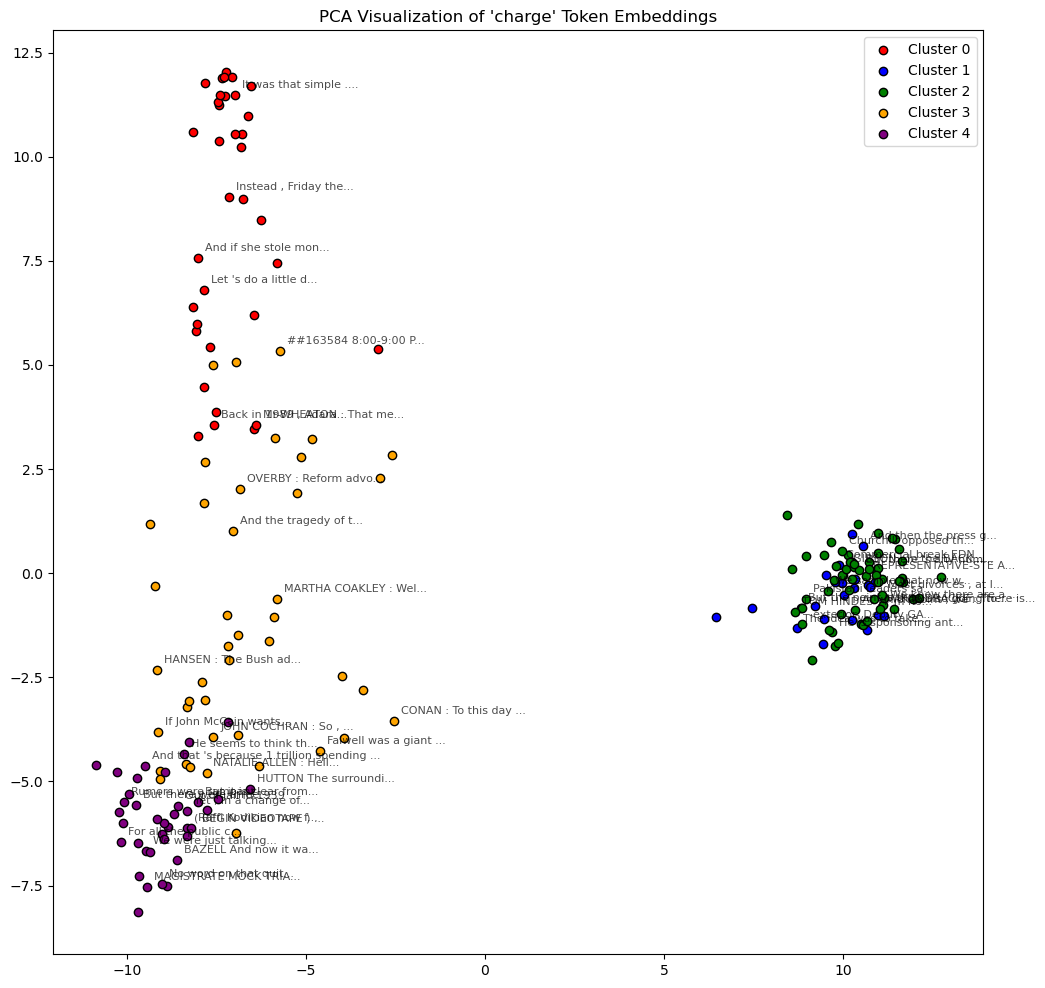


Cluster 0 examples:
Because if they do , you can often use that bank to use your ATM card without incurring a fee . The second is what kind of sur 	 charge 	  does your bank charge on a transaction . I have actually two ATM cards , one bank charges three percent .
---
BROWN : Well , this year , the farmers have gotten a little smarter because after putting up with people going through their fields for almost a decade now , they 've started to  	 charge 	  some people a pound to go take a look at a crop circle . Now there are tour groups being led in to see these crop circles , people selling T-shirts .
---
The question of medical malpractice , Melissa , is a civil claim by , let 's say , an estate , Michael Jackson 's estate . What the real concern here is , is will LAPD  	 charge 	  Dr. Murray -- Charles Murray , on whether or not his behavior was so reckless as to constitute a crime .
---

Cluster 1 examples:
-Iraqi raid in Sadr City . They were looking for a Mahdi militia commander

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import torch

np.random.seed(42)
torch.manual_seed(42)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

with open('problem3_data.txt', 'r') as file:
    passages = file.readlines()

def get_charge_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    layer_7_output = outputs.hidden_states[7][0]
    
    charge_positions = [i for i, id in enumerate(inputs['input_ids'][0]) if tokenizer.decode([id]) == "charge"]
    
    if not charge_positions:
        return None
    
    charge_embedding = layer_7_output[charge_positions[0]].numpy()
    
    return charge_embedding

embeddings = []
valid_passages = []

for passage in passages:
    embedding = get_charge_embedding(passage)
    if embedding is not None:
        embeddings.append(embedding)
        valid_passages.append(passage)

embeddings = np.array(embeddings)

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(embeddings)

def pca_visualize_embeddings(embeddings, passages, clusters):
    pca = PCA(n_components=2)
    twodim = pca.fit_transform(embeddings)
    
    plt.figure(figsize=(12, 12))

    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for i in range(5):
        cluster_points = twodim[clusters == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[i], label=f'Cluster {i}', edgecolors='k')
    
    plt.legend()
    
    sample_size = min(50, len(passages))
    sample_indices = np.random.choice(len(passages), sample_size, replace=False)
    
    for idx in sample_indices:
        x, y = twodim[idx]
        text = passages[idx].strip()[:20] + "..."
        plt.annotate(text, (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)
    
    plt.title("PCA Visualization of 'charge' Token Embeddings")
    
    plt.show()

pca_visualize_embeddings(embeddings, valid_passages, clusters)

# Print some examples from each cluster
for cluster in range(5):
    print(f"\nCluster {cluster} examples:")
    cluster_passages = [passage for passage, label in zip(valid_passages, clusters) if label == cluster]
    for passage in cluster_passages[:3]: 
        print(passage.strip())
        print("---")

cluster_df = pd.DataFrame({
    'passage': valid_passages,
    'cluster': clusters
})
cluster_df.to_csv('charge_clusters.csv', index=False)

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

def get_replacements(sentence, target_word, top_k=20):
    masked_sentence = sentence.replace(target_word, '[MASK]')
    inputs = tokenizer(masked_sentence, return_tensors='pt')
    mask_token_index = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1]
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    mask_token_logits = logits[0, mask_token_index, :]
    top_k_tokens = torch.topk(mask_token_logits, top_k, dim=1).indices[0].tolist()
    
    replacements = [tokenizer.decode([token]) for token in top_k_tokens]
    return replacements

with open('problem3_data.txt', 'r') as file:
    passages = file.readlines()

all_replacements = []
valid_passages = []
for passage in passages:
    if 'charge' in passage.lower():
        replacements = get_replacements(passage, 'charge')
        if ('charge' in replacements): 
            replacements.remove('charge')
        all_replacements.append(replacements)
        valid_passages.append(passage)

unique_replacements = list(set([word for sublist in all_replacements for word in sublist]))

vectors = []
for replacements in all_replacements:
    vector = [1 if word in replacements else 0 for word in unique_replacements]
    vectors.append(vector)

embeddings = np.array(vectors)

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Print some examples from each cluster
for cluster in range(5):
    print(f"\nCluster {cluster} examples:")
    cluster_passages = [passage for passage, label in zip(valid_passages, clusters) if label == cluster]
    for passage in cluster_passages[:3]:
        print(passage.strip())
        print("Replacements:", ', '.join(all_replacements[valid_passages.index(passage)]))
        print("---")

cluster_df = pd.DataFrame({
    'passage': valid_passages,
    'cluster': clusters,
    'replacements': [', '.join(rep) for rep in all_replacements]
})
cluster_df.to_csv('charge_replacement_clusters.csv', index=False)

c:\Users\acbar\miniconda3\envs\ai_env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (ini


Cluster 0 examples:
Mr-GORDON : Well , there 's an awful lot at stake in Najaf . The stakes could n't be higher . I think that the basic question is : Who is in  	 charge 	  in Iraq ? Or put it differently : Is anyone in charge in Iraq ? The great worry about Iraq fragmenting before we went in was just that question : Would there be someone to exercise the most basic function of a government , which is to maintain security and authority within the borders ?
Replacements: power, command, control, danger, authority, office, force, fact, hiding, trouble, government, place, operation, residence, business, iraq, jail, exile, particular
---
And this is n't all of the people in Iran . Understand this - ROSENBERG : Exactly right . BECK : These are people that are in  	 charge 	  right now , specifically Ahmadinejad , and even the Ayatollah Khomeini thought this cult which now controls the government , was so dangerous - true or false - he executed them .
Replacements: iran, tehran, power, ira